In [65]:
import numpy as np
import pandas as pd

import os
import cv2
import glob
import json
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

# Making lists of dataset files

In [45]:
file_path = '/aiffel/aiffel/AIFFEL_Hackathon/Mini_Hackathon'

train_jsons = sorted(glob.glob(file_path + '/train_json/train_objects_labeling/*'))

# Loading training meta data(json)

In [46]:
train_meta = []
for j in train_jsons:
    json_obj = json.load(open(j))
    # json_obj['features']
    for f in json_obj['features']:
        # geometry
        geo_coord = f['geometry']['coordinates']
        geo_type = f['geometry']['type']
        # properties
        object_imcoords = f['properties']['object_imcoords']
        object_angle = f['properties']['object_angle']
        building_imcoords = f['properties']['building_imcoords']
        road_imcoords = f['properties']['road_imcoords'] 
        image_id = f['properties']['image_id'] # 영상 ID
        ingest_time = f['properties']['ingest_time'] # 	영상 생성 시간
        type_id = f['properties']['type_id'] # 정수 (1~N), 클래스 id
        type_name = f['properties']['type_name'] # 클래스 이름

        # add to list
        train_meta.append([image_id, type_id, type_name, geo_coord, geo_type, object_angle,
                           object_imcoords, building_imcoords, road_imcoords, ingest_time])
# Make dataframe
df_train = pd.DataFrame(train_meta,
                        columns = ['image_id','type_id','type_name','geo_coord','geo_type','object_angle',
                                   'object_imcoords','building_imcoords','road_imcoords','ingest_time'])

### [test] ingest time 확인
날짜 혹은 시간에 의한 변수 확인을 위해 date, hour 을 counting한다.

```python
# 'ingest_time' value count 확인
df_train['ingest_time'].map(lambda x: str(x)).value_counts()
```

```python
# 'ingest_time' datetime 객체로 변환
df_train = df_train[['ingest_time']]

date_time = []
for t in df_train['ingest_time']:
    date_time.append(datetime.strptime(t, '%Y-%m-%dT%H:%M:%S.%fZ'))

date_time
```

```python
# datetime의 hour counting
hour_ = []

for a in date_time:
    hour_.append(a.hour)

count_hour = {}

for i in hour_:
    try: count_hour[i] += 1
    except: count_hour[i] = 1
        
print(count_hour)
```

```python
# datetime의 day counting
day_ = []

for a in date_time:
    day_.append(a.day)

count_day = {}

for i in day_:
    try: count_day[i] += 1
    except: count_day[i]=1

print(count_day)
```

In [6]:
def load_geojson(filename):
    """ Gets label data from a geojson label file

    :param (str) filename: file path to a geojson label file
    :return: (numpy.ndarray, numpy.ndarray ,numpy.ndarray) coords, chips, and classes corresponding to
            the coordinates, image names, and class codes for each ground truth.
    """

    with open(filename) as f:
        data = json.load(f)
        
    ## 각 출력값의 크기에 맞는 0으로 구성된 array를 생성해줍니다.
    
    obj_coords = np.zeros((len(data['features']), 8))
    image_ids = np.zeros((len(data['features'])), dtype='object')
    class_indices = np.zeros((len(data['features'])), dtype=int)
    class_names = np.zeros((len(data['features'])), dtype='object')
    
    ## geojson에 있는 실제값들을 위에서 생성한 변수들에 할당해줍니다.
    
    for idx in range(len(data['features'])):
        properties = data['features'][idx]['properties']
        image_ids[idx] = properties['image_id']
        obj_coords[idx] = np.array([float(num) for num in properties['bounds_imcoords'].split(",")])
        class_indices[idx] = properties['type_id']
        class_names[idx] = properties['type_name']

    return image_ids, obj_coords, class_indices, class_names

In [19]:
df_train.head(5)

,image_id,type_id,type_name,geo_coord,geo_type,object_angle,object_imcoords,building_imcoords,road_imcoords,ingest_time
0,OBJ00013_PS3_K3_NIA0078.png,3,civilian aircraft,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,6.283185,"469.1820926230315,473.2955533775398,561.654399...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
1,OBJ00013_PS3_K3_NIA0078.png,5,small car,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,3.547254,"993.6889260747658,339.4410959499382,988.810925...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
2,OBJ00013_PS3_K3_NIA0078.png,5,small car,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,3.647914,"988.7026551987746,331.54721860229455,984.09007...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
3,OBJ00013_PS3_K3_NIA0078.png,5,small car,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,0.607917,"935.9948592758786,141.9939151216178,940.820433...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
4,OBJ00013_PS3_K3_NIA0078.png,5,small car,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,3.612815,"873.1437932557097,45.11725293949537,871.080320...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z


In [20]:
df_train.shape

(423750, 10)

# 동일한 값을 갖는 컬럼 확인

In [21]:
df_train['geo_coord'].map(lambda x: str(x)).value_counts()

[[-99.2560382272, 19.5671796469, 0.0], [-99.250668751, 19.5671871844, 0.0], [-99.2506766199, 19.572276843, 0.0], [-99.2560462646, 19.5722693034, 0.0]]          1891
[[174.8172155564, -36.9081672643, 0.0], [174.8235331716, -36.9082832225, 0.0], [174.8236773429, -36.9032098873, 0.0], [174.8173601455, -36.9030939503, 0.0]]    1647
[[3.3548804675, 6.6122769696, 0.0], [3.3599753707, 6.6122733098, 0.0], [3.3599790581, 6.6173679768, 0.0], [3.3548841028, 6.6173716394, 0.0]]                    1537
[[143.1950957431, 42.8865178266, 0.0], [143.201987691, 42.8863854156, 0.0], [143.2021680601, 42.8914534288, 0.0], [143.1952755487, 42.8915858631, 0.0]]         1495
[[149.1880353012, -35.3169637695, 0.0], [149.1942266835, -35.3168515248, 0.0], [149.1940895617, -35.3117769001, 0.0], [149.1878985656, -35.3118891238, 0.0]]    1477
                                                                                                                                                                ... 
[[142.6273

In [22]:
df_train['geo_type'].value_counts()

Polygon    423750
Name: geo_type, dtype: int64

In [23]:
df_train['building_imcoords'].value_counts()

EMPTY    423750
Name: building_imcoords, dtype: int64

In [24]:
df_train['road_imcoords'].value_counts()

EMPTY    423750
Name: road_imcoords, dtype: int64

# 불필요 컬럼 제거 : 동일한 항목 4개와 수집시간

In [25]:
df_train = df_train[['image_id','type_id','type_name','object_angle','object_imcoords']]
df_train = df_train.sort_values(by = ['image_id','type_id']).reset_index(drop=True)
df_train.head(10)

,image_id,type_id,type_name,object_angle,object_imcoords
0,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.016708,"909.9167741757478,162.581938933753,909.2048358..."
1,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"913.0400862653505,168.7304042851768,912.285894..."
2,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"922.3328562982837,185.22684603509927,921.22870..."
3,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"923.7948935447157,188.82345704853282,922.55531..."
4,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"924.941725074188,192.42396790732408,924.158489..."
5,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"927.4439173492165,195.07374477833295,926.66068..."
6,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"935.9394923824259,212.65182271648013,935.15625..."
7,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.049191,"954.2558517619615,235.57994789454906,952.96648..."
8,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.085311,"979.8984342046227,290.93499226114074,977.99948..."
9,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.085311,"982.1837442708422,295.04385280103634,980.82157..."


# Object distribution per training images

In [26]:
df_image = df_train.image_id.value_counts().to_frame(name = 'obj_count') # obj 카운터 컬럼 넣기
df_image = df_image.join(df_train[['type_name','image_id']].drop_duplicates()['image_id'].value_counts()).rename(columns = {'image_id':'obj_nunique'})
df_img2obj = df_image.join(pd.crosstab(df_train['image_id'], df_train['type_name'])[df_train['type_name'].value_counts().index])
df_img2obj.head(3)

,obj_count,obj_nunique,small car,truck,small ship,train,bus,grouped container,individual container,swimming pool,...,civilian aircraft,large ship,crane,roundabout,helipad,outdoor playground,bridge,helicopter,dam,indoor playground
OBJ05158_PS3_K3A_NIA0336.png,1891,3,1874,16,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OBJ03758_PS3_K3A_NIA0157.png,1647,6,1530,97,0,0,1,2,8,0,...,0,0,0,0,0,0,0,0,0,0
OBJ03826_PS3_K3A_NIA0160.png,1537,3,1492,38,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df_img2obj.tail(3)

,obj_count,obj_nunique,small car,truck,small ship,train,bus,grouped container,individual container,swimming pool,...,civilian aircraft,large ship,crane,roundabout,helipad,outdoor playground,bridge,helicopter,dam,indoor playground
OBJ07365_PS3_K3A_NIA0798.png,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
OBJ00578_PS3_K3_NIA0085.png,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OBJ07359_PS3_K3A_NIA0791.png,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Training Image들의 객체 분포

## Sparse & Imbalanced -> Data Augmentation이 중요한 상황

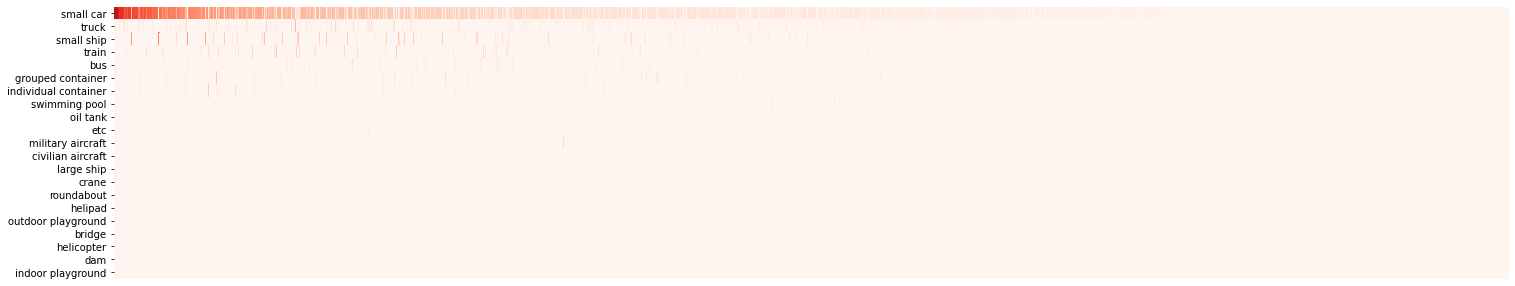

In [28]:
plt.figure(figsize = (25,5))
ax = sns.heatmap(df_img2obj.iloc[:,2:].transpose(), cmap='Reds', cbar=False, xticklabels=False)

## Object per single Image
* 사진 1장에 포함된 객체수의 분포
* 전체 분포와 'small car' 분포가 별 차이 없음

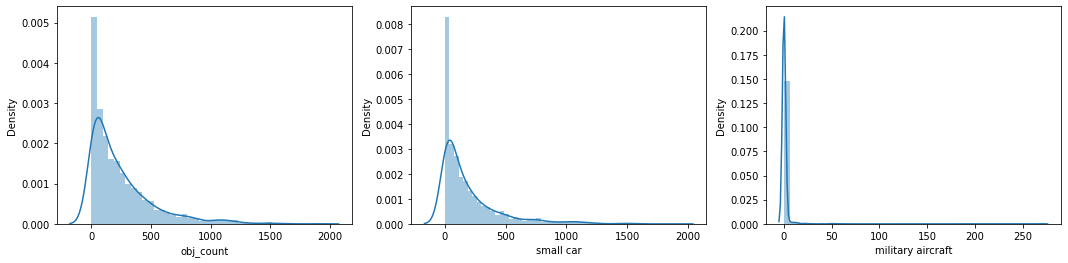

In [29]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
sns.distplot(df_img2obj['obj_count'], ax=axs[0])
sns.distplot(df_img2obj['small car'], ax=axs[1])
sns.distplot(df_img2obj['military aircraft'], ax=axs[2])
plt.show()

## Image에 포함된 고유한 객체 유형 수 1~10
* 고유한 객체유형(type_id)은 10개

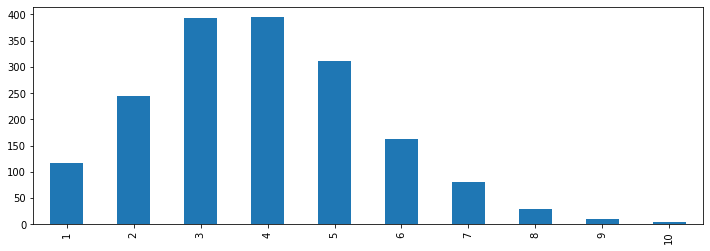

In [30]:
df_img2obj['obj_nunique'].value_counts().sort_index().plot.bar(figsize=(12,4))
plt.show()

# 객체유형별 전체 객체수(obj_count), 객체를 포함하는 이미지수(image_count)

In [31]:
df_object = df_train.type_name.value_counts().to_frame(name = 'obj_count')
df_object = df_object.join(df_train[['type_name','image_id']].drop_duplicates()['type_name'].value_counts()).rename(columns = {'type_name':'image_count'})
#df_object.plot.barh(figsize=(12,6))

In [32]:
df_object

,obj_count,image_count
small car,334199,1623
truck,27067,1317
small ship,19238,294
train,10331,154
bus,8698,827
grouped container,8069,322
individual container,5959,347
swimming pool,2188,194
oil tank,1631,117
etc,1542,230


<AxesSubplot:ylabel='image_count'>

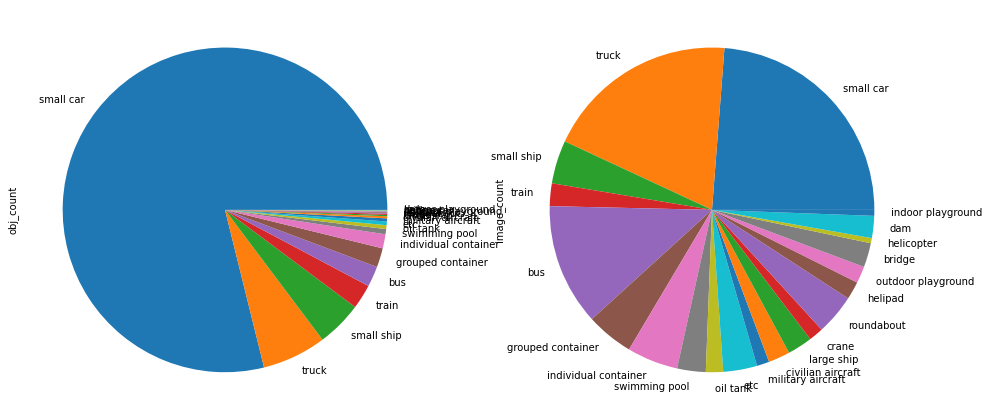

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
df_object['obj_count'].plot.pie(ax=axs[0])
df_object['image_count'].plot.pie(ax=axs[1])

## Split Object Coordinates

In [34]:
imcoords_columns = []
for i in range(4):
    df_train['p{}_x'.format(i+1)] = 0.0
    df_train['p{}_y'.format(i+1)] = 0.0
    imcoords_columns.append('p{}_x'.format(i+1))
    imcoords_columns.append('p{}_y'.format(i+1))

# Parse 'object_imcoords'
df_train[imcoords_columns] = df_train.apply(lambda x: list(map(float, x['object_imcoords'].split(','))), axis=1, result_type='expand')
df_train.head(3)

,image_id,type_id,type_name,object_angle,object_imcoords,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y
0,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.016708,"909.9167741757478,162.581938933753,909.2048358...",909.916774,162.581939,909.204836,161.092600,917.764564,157.000853,918.476503,158.490193
1,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"913.0400862653505,168.7304042851768,912.285894...",913.040086,168.730404,912.285894,167.262010,927.274976,159.563363,928.029169,161.031758
2,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"922.3328562982837,185.22684603509927,921.22870...",922.332856,185.226846,921.228703,183.077086,939.093852,173.901242,940.198005,176.051003


In [35]:
df_train['type_id'] = df_train['type_id'].astype(int)

df_types = df_train[['type_id','type_name']].drop_duplicates().sort_values(by='type_id').reset_index(drop=True)
df_types.index = df_types.index + 1

# type_id : type_name
type_name_dict = df_types['type_name'].to_dict()

# Object Type : Color (plt.cm.tab20b)
type_colors = dict(zip(type_name_dict.keys(), plt.cm.tab20.colors))

## Display Image & Objects
* 사진과 객체를 출력해주는 유틸리티 함수

In [38]:
def show_n_mask(image_id, obj_type=None, gray_mode=True):
    file_path = '/aiffel/aiffel/AIFFEL_Hackathon/Mini_Hackathon/train_image/train_objects_data/'
    fig= plt.figure(figsize=(18,18))
    # plot image
    img = cv2.imread(file_path + image_id, cv2.COLOR_BGR2RGB)
    if gray_mode:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray')
    else:
        plt.imshow(img)
    
    # All object or selected objects(obj_type)
    for idx, row in df_train[df_train.image_id == image_id][['type_id','type_name']+imcoords_columns].iterrows():
        if (obj_type==row.type_name):
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.type_id], edgecolor=type_colors[row.type_id], linewidth=2, alpha=0.5)
            # Label 'type_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.type_id), color='white', fontsize=12, fontweight='semibold')
        elif obj_type == None:
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.type_id], edgecolor=type_colors[row.type_id], linewidth=2, alpha=0.5)
            # Label 'type_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.type_id), color='white', fontsize=12, fontweight='semibold')
    plt.show()

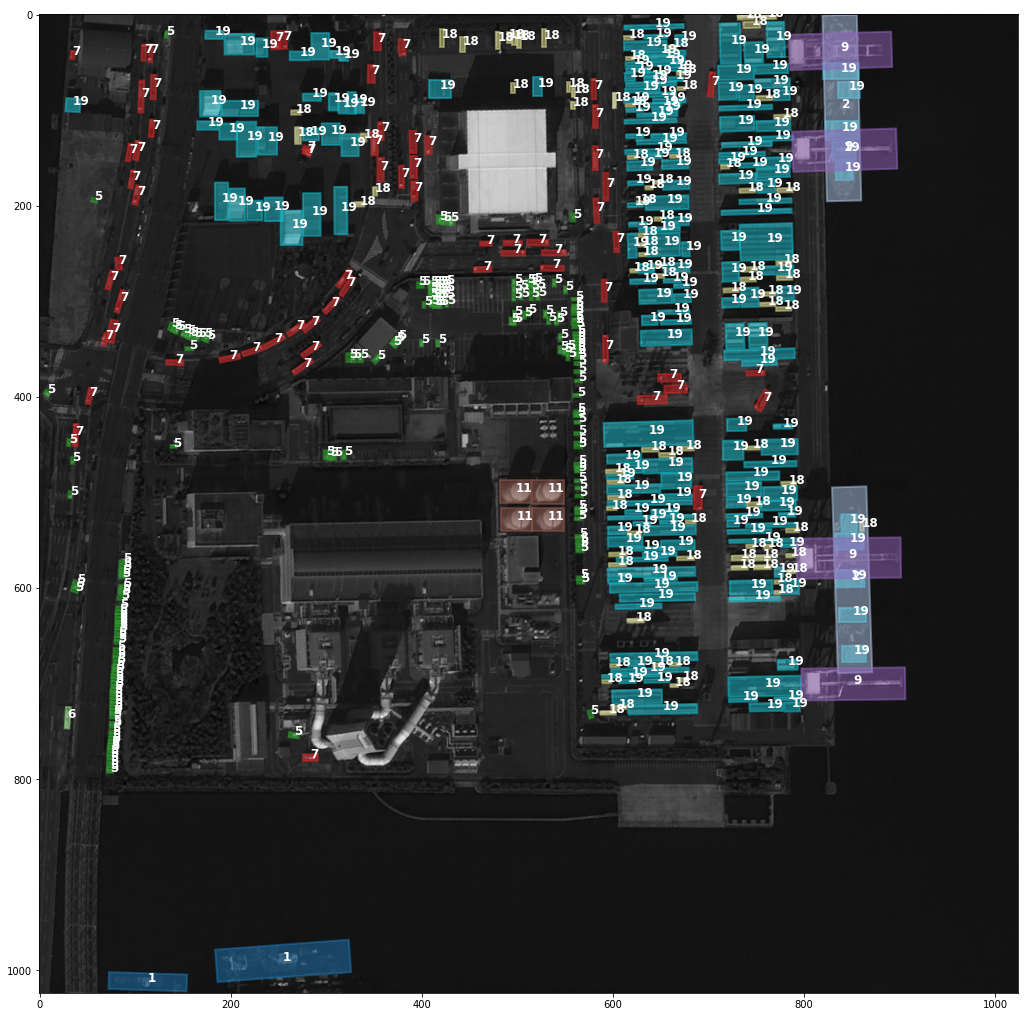

In [39]:
show_n_mask('OBJ00028_PS3_K3_NIA0078.png')

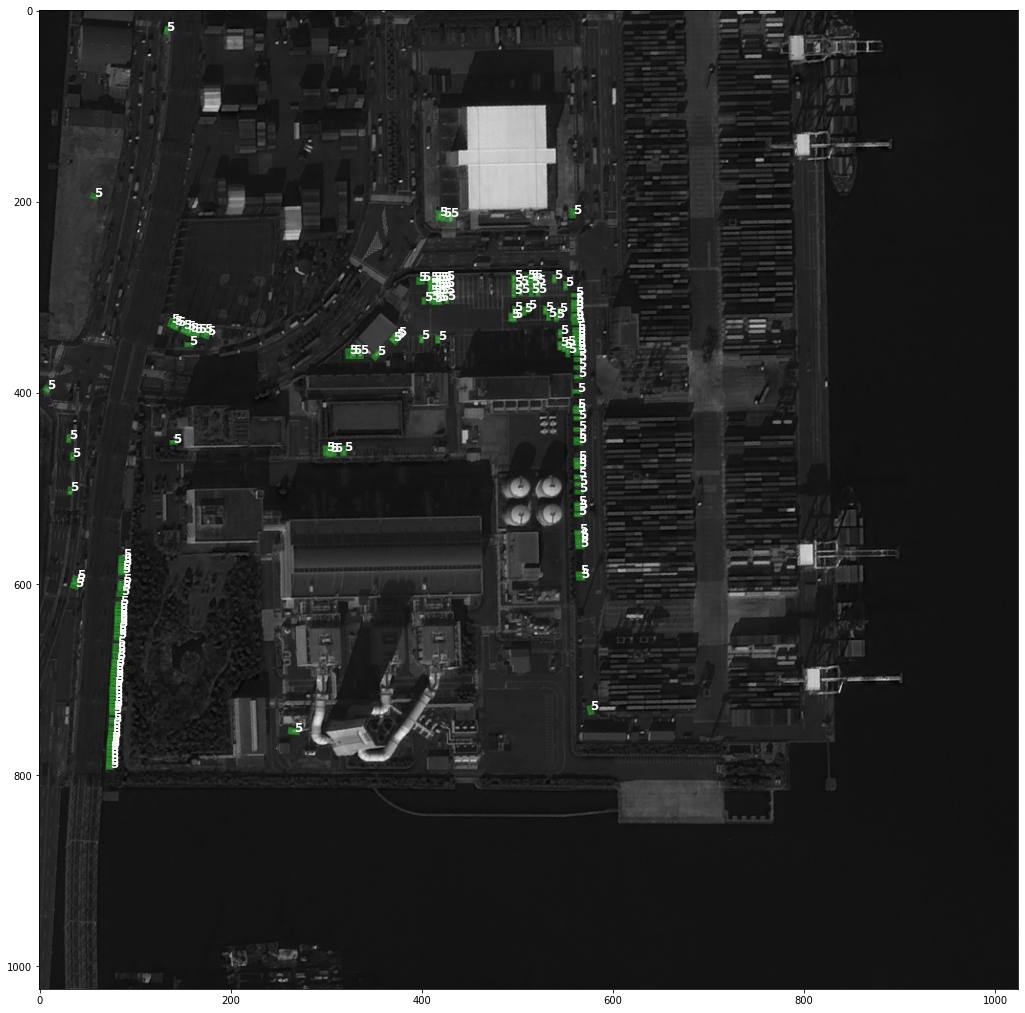

In [40]:
show_n_mask('OBJ00028_PS3_K3_NIA0078.png', 'small car')

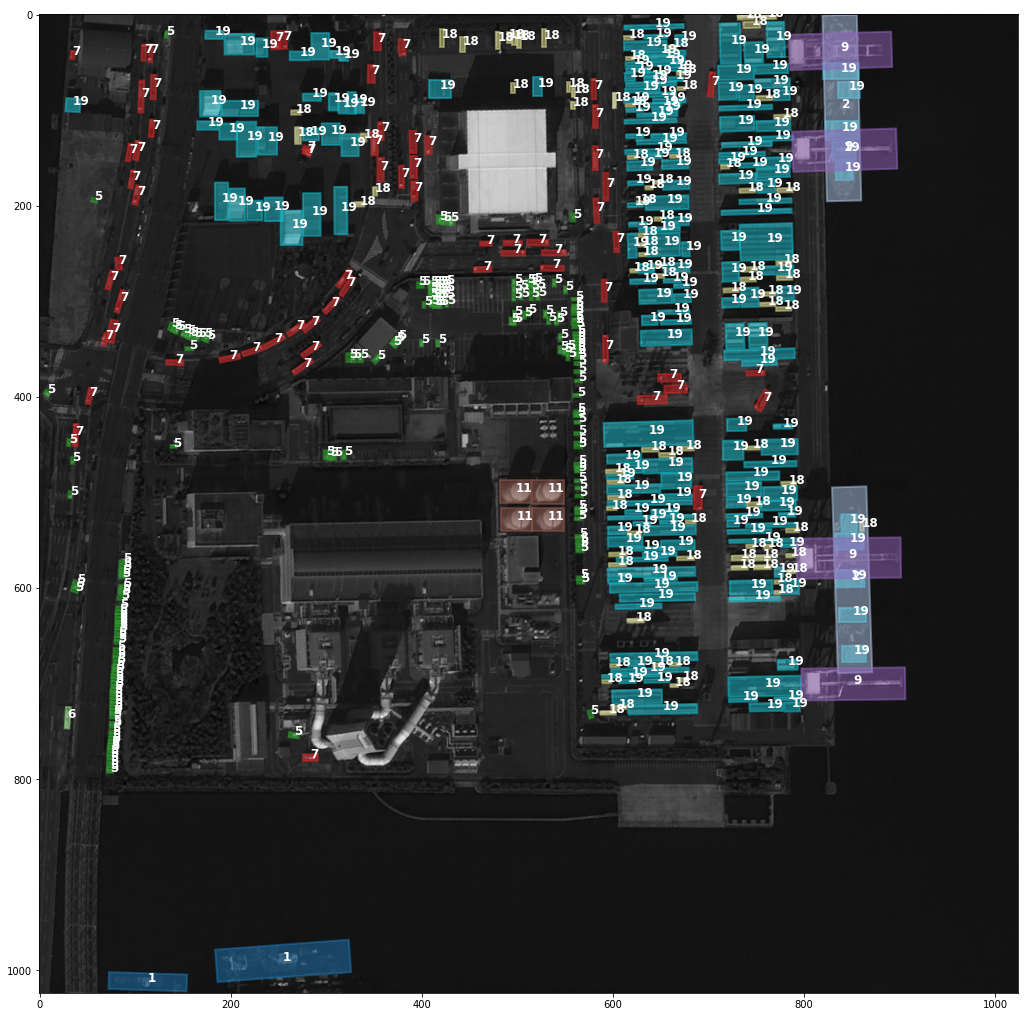

In [41]:
show_n_mask('OBJ00028_PS3_K3_NIA0078.png')